In [330]:
import numpy as np
import pandas as pd
from scipy import signal
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid 

In [408]:

def frum_inner(t:float, U:float, U0:float, r:float)->float:
    return np.exp((U-U0-r*t)/0.0256)/(1+np.exp((U-U0-r*t)/0.0256))-t

def calculate_theta(U:np.array, U0:float, r:float)->np.array:
    theta = np.full(len(U), np.nan)
    for n in range(len(U)):
        def Frum_wapper(t):
            return frum_inner(t, U[n], U0, r)
        theta[n] = fsolve(Frum_wapper, 0.5)[0]  # Extract single element
    return theta


def calcualte_all_thetas(U:np.array, U0_l:list=[0.3,0.5,0.8], r_l:np.array=[0,0.2,0.1])->np.array:
    data=pd.DataFrame(index=U)
    for i in range(len(r_l)):
        data[f'U0={U0_l[i]}, r={r_l[i]}']=calculate_theta(U, U0_l[i], r_l[i])
        data.index.name='U'
    return data

def df_deriv(df:pd.DataFrame)->pd.DataFrame:
    dx=pd.DataFrame(df.index.values).diff().values.flatten()
    dy = df.diff(axis=0)
    dydx = pd.DataFrame({col: dy[col] / dx for col in dy.columns})
    return dydx


def Gau(WL, mu, sigma):
    return (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((WL - mu) / sigma)**2)

def multi_gau(WL:np.array, mu_l:list, sigma_l:list=[100,100,100]):
    y = np.zeros(len(WL))
    for i in range(len(mu_l)):
        y += Gau(WL, mu_l[i], sigma_l[i])
    return y/y.max()

def generate_alpha_bar_spectra(WL:np.array, mu_df:list[list], sigma_df:list[list])->pd.DataFrame:
    data=pd.DataFrame(index=WL)
    for i in range(len(mu_df)):
        data[f'alpha_bar_{i}']=multi_gau(WL, mu_df[i], sigma_df[i])
        data.index.name='WL'
    return data

def generate_SpEC(WL:np.array, U:np.array, alpha_bar_all:pd.DataFrame, theta_all:pd.DataFrame, Q_max_all:list, alpha_max_all:list)->pd.DataFrame:
    # collumn wise multiply alpha_bar_all by alpha_max_all using pd.mul
    alpha_all=alpha_bar_all.mul(alpha_max_all, axis=1)
    # collumn wise multiply theta_all by Q_max_all using pd.mul
    Q_all=theta_all.mul(Q_max_all, axis=1)
    # matrix multiply alpha_all by Q_all
    print(alpha_all.shape, Q_all.T.shape)

    SpEC=pd.DataFrame(np.matmul(np.array(alpha_all), np.array(Q_all.T)))

    SpEC.index=WL
    SpEC.columns=U


    return SpEC

def calculate_Q(all_thetas:pd.DataFrame, Q_max_all:list)->pd.DataFrame:
    return pd.DataFrame(all_thetas.mul(Q_max_all, axis=1), index=all_thetas.index, columns=all_thetas.columns)

def calculate_J_cap(Q_all:pd.DataFrame, scan_rate:float=0.01)->pd.DataFrame:
    return df_deriv(Q_all).multiply(scan_rate)


def calculate_BEP_cat_current(all_thetas:pd.DataFrame, alpha:float=0.5)->pd.DataFrame:
    theta=all_thetas.iloc[:,-1]
    J_cat=np.exp(-13)*theta*np.exp(-(alpha*-0.8*theta)/0.059)
    return pd.DataFrame(J_cat)

def calculate_current(all_thetas:pd.DataFrame, Q_max_all:list, scan_rate:float=0.01)->pd.DataFrame:
    Q_all=calculate_Q(all_thetas, Q_max_all)
    J_cap=pd.DataFrame(calculate_J_cap(Q_all, scan_rate).sum(axis=1))
    J_cat=pd.DataFrame(calculate_BEP_cat_current(all_thetas))

    J_cap.columns=[0]
    J_cat.columns=[0]


    J=np.array(J_cap)+np.array(J_cat)

    return pd.DataFrame(J, index=Q_all.index)

def exp_dec(t:float, a:float, b:float)->float:
    return a*np.exp(-b*t)

def minus_exp_dec(t:float, a:float, b:float)->float:
    return -a*np.exp(-b*t)

def str_exp_dec(t:float, a:float, b:float, c= 0, alpha:float=0.2)->float:
    return -a*(np.exp(-b*t+c)) ** alpha

def linear_decay(t:float, a:float, b:float)->float:
    return a-b*t

def get_nearest_value_to_index(input_df:pd.DataFrame, value:float)->float:
    index_val=(np.abs(input_df.index.values-value)).argmin()
    return input_df.iloc[index_val]


def Q_for_component_in_U_window(comp: int, U1: float, U2: float, Q_all: pd.DataFrame) -> float:
    # get the Q values for the component
    Q = Q_all.iloc[:, comp]
    # get the Q values closest to U1 and U2
    Q_U1 = get_nearest_value_to_index(Q, U1)
    Q_U2 = get_nearest_value_to_index(Q, U2)
    #print(Q_U1, Q_U2)
    # return the sum of Q values in the window

    return np.round((Q_U2 - Q_U1),5)


def piecewise_exp_dec(t: np.ndarray, a: float, b: float, t1: float, t2: float) -> np.ndarray:
    J = np.zeros_like(t, dtype=float)
    J[t <= t1] = 0
    J[(t > t1) & (t <= t2)] = exp_dec(t[(t > t1) & (t <= t2)] - t1, a, b)
    J[t > t2] = minus_exp_dec(t[t > t2] - t2, a, b)
    return J

def piecewise_exp_rise_str_exp_dec(t: np.ndarray, a: float, a1:float, b: float, b1:float, t1: float, t2: float) -> np.ndarray:
    J = np.zeros_like(t, dtype=float)
    J[t <= t1] = 0
    J[(t > t1) & (t <= t2)] = exp_dec(t[(t > t1) & (t <= t2)] - t1, a, b)
    J[t > t2] = str_exp_dec(t[t > t2] - t2, a1, b1)
    #J[t > t2]=np.where(J[t > t2]>0, J, 0)
    return J






def piecewise_exp_dec_integrated(t: np.ndarray, a: float, b: float, t1: float, t2: float) -> np.ndarray:
    """numerically integrate the piecewise exponential decay function"""
    J = np.zeros_like(t, dtype=float)
    J=piecewise_exp_dec(t, a, b, t1, t2)
    return cumulative_trapezoid(J, t, initial=0)

def piecewise_exp_rise_str_exp_dec_integrated(t: np.ndarray, a: float, a1:float, b: float, b1:float, t1: float, t2: float) -> np.ndarray:
    """numerically integrate the piecewise exponential decay function"""
    J = np.zeros_like(t, dtype=float)
    J=piecewise_exp_rise_str_exp_dec(t, a, a1, b, b1, t1, t2)
    Q = cumulative_trapezoid(J, t, initial=0)
    #Q=np.where(Q<0,0,Q)
    return Q



def max_PW_exp_dec_integrated(t: np.ndarray, a: float, b: float, t1: float, t2: float) -> float:
    return piecewise_exp_dec_integrated(t, a, b, t1, t2).max()

def max_piecewise_exp_rise_str_exp_dec_integrated(t: np.ndarray, a: float, a1:float, b: float, b1:float, t1: float, t2: float) -> float:
    return piecewise_exp_rise_str_exp_dec_integrated(t, a, a1, b, b1, t1, t2).max()


def calculate_a_for_Q(Q:float, t:float,  b:float, t1:float, t2:float,a_start:float=0)->float:
    def pw_max_wrapper(a):
        return max_PW_exp_dec_integrated(t, a, b, t1, t2)-Q
    return fsolve(pw_max_wrapper, a_start)[0]


def get_nearest_spectrum_to_U(SpEC:pd.DataFrame, U:float)->pd.array:
    index_val=(np.abs(SpEC.columns.values-U)).argmin()
    return SpEC.iloc[:,index_val]  

def get_diff_U1_U2(SpEC:pd.DataFrame, U1:float, U2:float)->pd.array:
    SpEC_U1=get_nearest_spectrum_to_U(SpEC, U1)
    SpEC_U2=get_nearest_spectrum_to_U(SpEC, U2)
    return SpEC_U2-SpEC_U1

def PW_J_for_U1_U2(U1:float, U2:float, Q_all:pd.DataFrame, t:np.array, b:float, t1:float, t2:float)->pd.DataFrame:
    """This function 1. calculates Q for U1 and U2 in Q_all.sum
    2. calculates a for Q1 and Q2"""
    Q=0
    for i in range(Q_all.shape[1]):
        Q+= Q_for_component_in_U_window(i, U1, U2, Q_all)
    
    a=calculate_a_for_Q(Q=Q, t=t, b=b, t1=t1, t2=t2)

    J=piecewise_exp_dec(t, a, b, t1, t2)

    return pd.DataFrame(J, index=t)

def calculate_PD_dynamics_at_U2(U2:float, U1:float, all_thetas:pd.DataFrame, Q_all:pd.DataFrame, t:np.array, b:float=0.5, b1:float=0.1, t1:float=10, t2:float=60, plotbool:bool=False)->pd.DataFrame:
    J=calculate_BEP_cat_current(all_thetas)
    JBEP=get_nearest_value_to_index(J, U2).values[0]
    # fraction_to_decay=0.5
    Q_step=Q_for_component_in_U_window(Q_all.shape[1]-1, U1, U2, Q_all)
    # print(f'U2 is {U2}, JBEP is {JBEP}, Qstep is {Q_step}')
    a1t=JBEP
    a_Q=calculate_a_for_Q(Q=Q_step,t=t,b=1,t1=t1,t2=t2)
    # print(f'a_Q is {a_Q}')
    PDJt=piecewise_exp_rise_str_exp_dec(t=t, a=a_Q, a1=a1t,  b=b, b1=b1,  t1=t1, t2=t2)
    PDQt=piecewise_exp_rise_str_exp_dec_integrated(t=t, a=a_Q, a1=a1t,  b=b, b1=b1, t1=t1, t2=t2)
    if plotbool:
        fig, ax = plt.subplots(2,1 )
        ax[0].plot(t, PDJt)
        ax[1].plot(t, PDQt)
        #add horizontal line at JBEP
        ax[0].axhline(y=-1*JBEP.values[0], color='r', linestyle='--')
    return t, PDQt, PDJt


    #a1=test_a1_for_Q(Q=Q,t=t,b1=b1,a_1_start=0, t2=t2)
    
 

    print(f'Q is {Q},a is {a},a1 is {a1}, b1 is {b1}')

    J=piecewise_exp_rise_str_exp_dec(t=t, a=a, a1=a1, b=b, b1=b1, t1=t1, t2=t2)

    Q_rise=J[t<t2].cumsum()[-1]
    Q_fall=J[t>t2].cumsum()[-1]

    print(f'riseQ {Q_rise}, fallQ={Q_fall}')


    return J



def SW_SpEC(SpEC: pd.DataFrame, U1:float, U2:float, Q_all:pd.DataFrame, t:np.array, b:float, t1:float, t2:float)->pd.DataFrame:
    """This function 1. calculates the difference between SpEC for U1 and U2
    2. calculates the PW_J for U1 and U2
    3. Uses np.outer to calculate the SW_SpEC time evolution"""
    SpEC_diff=pd.DataFrame(get_diff_U1_U2(SpEC, U1, U2))
    J_t=PW_J_for_U1_U2(U1, U2, Q_all, t, b, t1, t2)
    Q_t=cumulative_trapezoid(J_t.values.flatten(), t, initial=0)

    SW_SpEC=np.outer(SpEC_diff, Q_t)
    return pd.DataFrame(SW_SpEC, index=SpEC.index, columns=t)

def PD_SpEC(SpEC:pd.DataFrame,U1:float, U2:float, all_thetas:pd.DataFrame, Q_all:pd.DataFrame, t:np.array, b:float, b1:float, t1:float, t2:float)->pd.DataFrame:
    """This function 1. calculates the difference between SpEC for U1 and U2
    2. calculates the PD_J for U1 and U2
    3. Uses np.outer to calculate the PD_Spec time evolution"""
    SpEC_diff=pd.DataFrame(get_diff_U1_U2(SpEC, U1, U2))
    t, PDQt, PDJt=calculate_PD_dynamics_at_U2(U2, U1, all_thetas, Q_all, t, b, b1, t1, t2)
    PD_Spec=np.outer(SpEC_diff, PDQt)
    return pd.DataFrame(PD_Spec, index=SpEC.index, columns=t)


def intrinsic_rate(Q_all:pd.DataFrame, J_BEP:pd.DataFrame)->pd.DataFrame:
    J_BEP.columns=[0]
    Qf=pd.DataFrame(Q_all.iloc[:,-1])
    Qf.columns=[0]
    return J_BEP.divide(Qf,axis=0)






In [332]:
#Q_all.diff(axis=0).multiply(0.01).cumsum(axis=0).sum(axis=1).plot()
#calculate_J_cap(Q_all=Q_all,scan_rate=scan_rate).cumsum(axis=0).divide(scan_rate).plot()

In [333]:
#plt.plot(t[t>60]-60,str_exp_dec(t[t>60]-60, a=0.0298,b=0.01).cumsum())

(700, 1) (700, 1)
(50, 3) (3, 700)


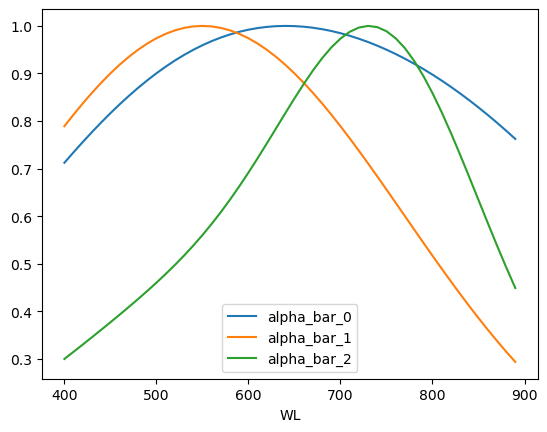

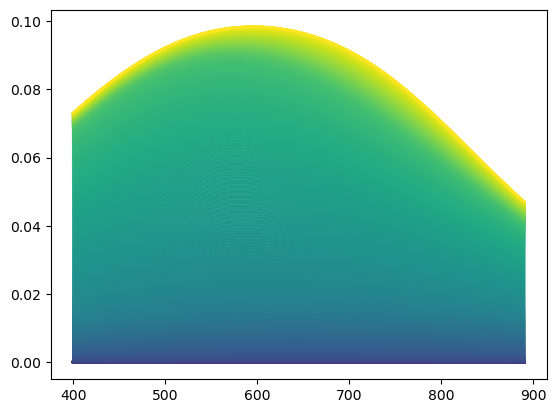

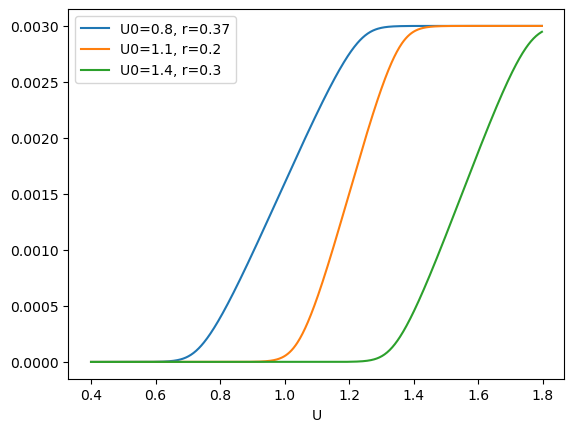

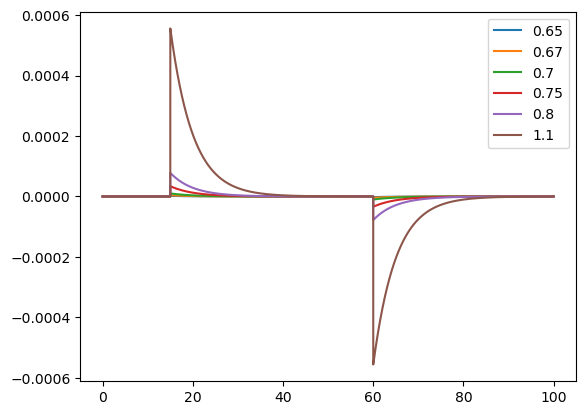

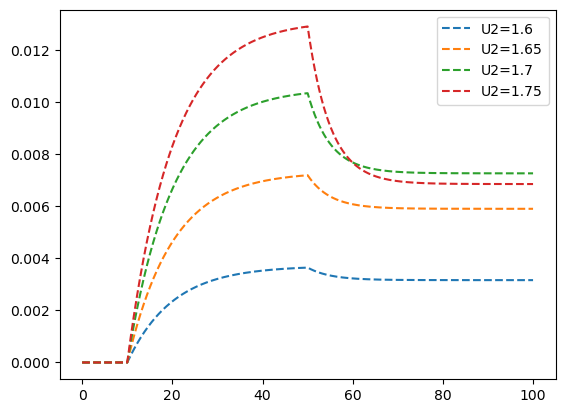

In [407]:
if __name__ == "__main__":

    #1. Define the parameters for SpEC
    E=np.arange(0.4,1.8,0.002) # here is the E aray we use to calculate the theta values from the frumkin equation
    # for nice plots later keep the upper limit of E about 0.5 V more than E02 (note this will depend on the r value that you choose)
    E0_l=[0.8,1.1,1.4] # list of standard potentials
    r_l=[0.37,0.2,0.3] # list of itneraction enthalpies in eV
    WLs=np.arange(400,900,10) # Wavelengths
    mu_all=[[450,900,650],[450,550,650],[550,700,750]] # list of mu values for the gaussian peaks
    sigma_all=[[200,200,200],[200,200,200],[200,200,100]] # list of sigma values for the gaussian peaks
    alphas=[10,20,5]# these are the peak values of Delta alpha for each component in units of Delta OD
    Q_max_all=[0.003,0.003,0.003]# the maximum Q values for each component in units of C/cm^2
    scan_rate=0.01

    # define the parameters for the SW-SpEC
    t=np.arange(0, 100, 0.01) # this defines the time resolution of the measurment
    b1=0.2 # this is the rate constant for the exponential function that models the chaginf transient - note the real function is not exponential but this is a nice approximation
    t1=15 # this is the time at which U2 is applied
    t2=60 # this is the time at which U1 is applied


    #3. calculate the fundamental parameters for the SpEC


    all_thetas=calcualte_all_thetas(U=E, U0_l=E0_l, r_l=r_l)
    all_alpha_bar=generate_alpha_bar_spectra(WLs, mu_all, sigma_all)
    Q_all=calculate_Q(all_thetas, Q_max_all)
    J_total=calculate_current(all_thetas, Q_max_all, scan_rate=scan_rate)
    SpEC=generate_SpEC(WLs, E, all_alpha_bar, all_thetas, Q_max_all, alphas)

    all_alpha_bar.plot()  
    SpEC.plot(colormap='viridis', legend=False)
    Q_all.plot()


    #4 calculate the SW-SpEC

    # first the spectra
    SW1=SW_SpEC(SpEC=SpEC, U1=0.6, U2=0.65, Q_all=Q_all, t=t, b=b1, t1=t1, t2=t2)
    SW2=SW_SpEC(SpEC=SpEC, U1=0.6, U2=0.67, Q_all=Q_all, t=t, b=b1, t1=t1, t2=t2)
    SW3=SW_SpEC(SpEC=SpEC, U1=0.6, U2=0.7, Q_all=Q_all, t=t, b=b1, t1=t1, t2=t2)
    SW4=SW_SpEC(SpEC=SpEC, U1=0.6, U2=0.75, Q_all=Q_all, t=t, b=b1, t1=t1, t2=t2)
    SW5=SW_SpEC(SpEC=SpEC, U1=0.6, U2=0.8, Q_all=Q_all, t=t, b=b1, t1=t1, t2=t2)
    SW6=SW_SpEC(SpEC=SpEC, U1=0.6, U2=1.1, Q_all=Q_all, t=t, b=b1, t1=t1, t2=t2)

    # pack all the SW into a dictionary, with keys of U2
    SW_SpEC_all={0.65:SW1, 0.67:SW2, 0.7:SW3, 0.75:SW4, 0.8:SW5, 1.1:SW6}

    # then the J
    J1=PW_J_for_U1_U2(U1=0.6, U2=0.65, Q_all=Q_all, t=t, b=b1, t1=t1, t2=t2)
    J2=PW_J_for_U1_U2(U1=0.6, U2=0.67, Q_all=Q_all, t=t, b=b1, t1=t1, t2=t2)
    J3=PW_J_for_U1_U2(U1=0.6, U2=0.7, Q_all=Q_all, t=t, b=b1, t1=t1, t2=t2)
    J4=PW_J_for_U1_U2(U1=0.6, U2=0.75, Q_all=Q_all, t=t, b=b1, t1=t1, t2=t2)
    J5=PW_J_for_U1_U2(U1=0.6, U2=0.8, Q_all=Q_all, t=t, b=b1, t1=t1, t2=t2)
    J6=PW_J_for_U1_U2(U1=0.6, U2=1.1, Q_all=Q_all, t=t, b=b1, t1=t1, t2=t2)

    # pack all Js into a dataframe with titles of U1 and U2
    J_all=pd.concat([J1,J2,J3,J4, J5, J6], axis=1)
    J_all.columns=[0.65, 0.67, 0.7, 0.75, 0.8, 1.1]
    J_all.index=t


    

    #5. plot the SW-SpEC as a heatmap
    #plt.imshow(SW1, aspect='auto', cmap='viridis', interpolation='nearest')

    # plot the J as a new fig, ax
    fig2, ax2 = plt.subplots()
    J_all.plot(ax=ax2)

    # generate the charge and current for the PD dynamics
    U1=1.55
    U2_array=np.arange(1.6,1.8,0.05)
    PD_dyn={}
    for U2 in U2_array:
        PD_dyn[U2]=calculate_PD_dynamics_at_U2(U2, U1, all_thetas, Q_all, t, b=0.1, b1=1, t1=10, t2=50)

    fig3, ax3 = plt.subplots()
    i=0
    for t, PDQt, PDJt in PD_dyn.values():
        ax3.plot(t, PDQt, linestyle='--', label=f'U2={np.round(U2_array[i],3)}')
        i+=1
    ax3.legend()
    
    


   

    


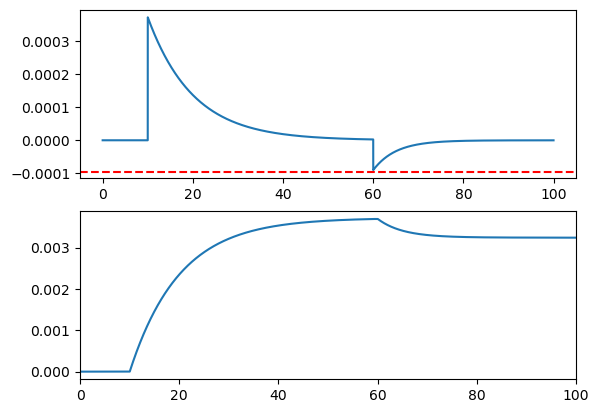

In [385]:
J=calculate_BEP_cat_current(all_thetas)
U1=1.55
U2=1.6
JBEP=get_nearest_value_to_index(J, U2)
fraction_to_decay=0.5
Qtest=Q_for_component_in_U_window(2, U1, U2, Q_all)*fraction_to_decay
t2t=60
t_t=t[t>t2t]-t2t
bt=1
a1t=0.00009
a=calculate_a_for_Q(Q=Qtest/fraction_to_decay,t=t,b=1,t1=20,t2=t2t)
fig, ax = plt.subplots(2,1 )
PDJt=t,piecewise_exp_rise_dual_dec(t=t, a=a, a1=a1t, a2=0.0000001, b=0.1, b1=bt, b2=0.003, t1=10, t2=60)
PDQt=t,piecewise_exp_rise_dual_dec_integrated(t=t, a=a, a1=a1t, a2=0.0000001, b=0.1, b1=bt, b2=0.003, t1=10, t2=60)
# test=str_exp_dec(t=t_t,a=a1t,b=bt)
ax[1].plot(*PDQt)
ax[0].plot(*PDJt)
# plt.plot(t_t, test, color='red')
plt.xlim(0,100)
# plt.ylim(0,-0.0001)
# add a horizontal line at for -JBEP at x=0
ax[0].axhline(-JBEP.values, color='red', linestyle='--')

# in a new 



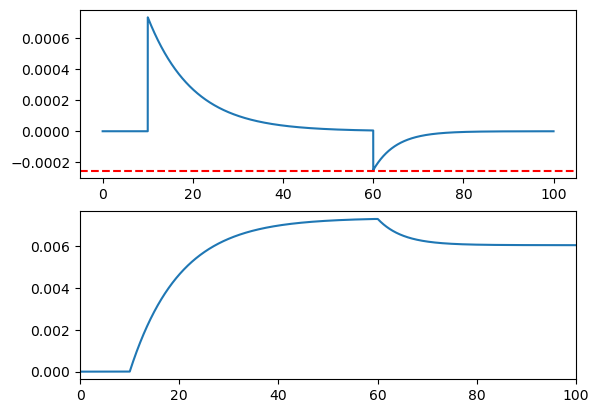

In [336]:
J=calculate_BEP_cat_current(all_thetas)
U1=1.55
U2_2=1.65
JBEP2=get_nearest_value_to_index(J, U2_2)
fraction_to_decay=0.5
Qtest=Q_for_component_in_U_window(2, U1, U2_2, Q_all)*fraction_to_decay
t2t=60
t_t=t[t>t2t]-t2t
bt=1
a1t=0.00025
a=calculate_a_for_Q(Q=Qtest/fraction_to_decay,t=t,b=1,t1=20,t2=t2t)
fig, ax = plt.subplots(2,1 )
PDJt=t,piecewise_exp_rise_dual_dec(t=t, a=a, a1=a1t, a2=0.0000001, b=0.1, b1=bt, b2=0.003, t1=10, t2=60)
PDQt=t,piecewise_exp_rise_dual_dec_integrated(t=t, a=a, a1=a1t, a2=0.0000001, b=0.1, b1=bt, b2=0.003, t1=10, t2=60)
# test=str_exp_dec(t=t_t,a=a1t,b=bt)
ax[1].plot(*PDQt)
ax[0].plot(*PDJt)
# plt.plot(t_t, test, color='red')
plt.xlim(0,100)
# plt.ylim(0,-0.0001)
# add a horizontal line at for -JBEP at x=0
ax[0].axhline(-JBEP2.values, color='red', linestyle='--')

# in a new 



U2 is 1.9, JBEP is U0=1.4, r=0.3    0.001736
Name: 1.7980000000000014, dtype: float64, Qstep is 0.00145
a_Q is 0.0014572742272043763


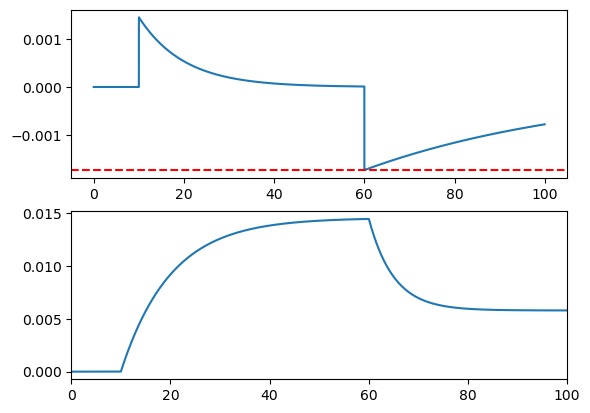

In [386]:
def calculate_PD_dynamics_at_U2(U2:float, U1:float, all_thetas:pd.DataFrame, Q_all:pd.DataFrame, t:np.array, b:float=0.5, b1:float=2, t1:float=10, t2:float=60)->pd.DataFrame:
    J=calculate_BEP_cat_current(all_thetas)
    JBEP=get_nearest_value_to_index(J, U2)
    # fraction_to_decay=0.5
    Q_step=Q_for_component_in_U_window(Q_all.shape[1]-1, U1, U2, Q_all)
    print(f'U2 is {U2}, JBEP is {JBEP}, Qstep is {Q_step}')
    a1t=JBEP.values
    a_Q=calculate_a_for_Q(Q=Q_step,t=t,b=1,t1=t1,t2=t2)
    print(f'a_Q is {a_Q}')
    fig, ax = plt.subplots(2,1 )
    PDJt=piecewise_exp_rise_str_exp_dec(t=t, a=a_Q, a1=a1t,  b=b, b1=b1,  t1=t1, t2=t2)
    PDQt=piecewise_exp_rise_str_exp_dec_integrated(t=t, a=a_Q, a1=a1t,  b=b, b1=bt, t1=t1, t2=t2)
    test=str_exp_dec(t=t_t,a=a1t,b=bt)
    ax[1].plot(t, PDQt)
    ax[0].plot(t, PDJt)
    # plt.plot(t_t, test, color='red')
    plt.xlim(0,100)
    # plt.ylim(0,-0.0001)
    # add a horizontal line at for -JBEP at x=0
    ax[0].axhline(-JBEP.values, color='red', linestyle='--')

    b1

# in a new 
U1=1.55
U2_5=1.9

calculate_PD_dynamics_at_U2(U2_5, U1, all_thetas, Q_all, t, b=0.1, b1=0.1, t1=10, t2=60)


In [403]:
U2_array=np.arange(1.6,1.8,0.05)
PD_data={}

for U2 in U2_array:
    PD_data[U2]=calculate_PD_dynamics_at_U2(U2, U1, all_thetas, Q_all, t, b=0.1, b1=0.1, t1=10, t2=50)





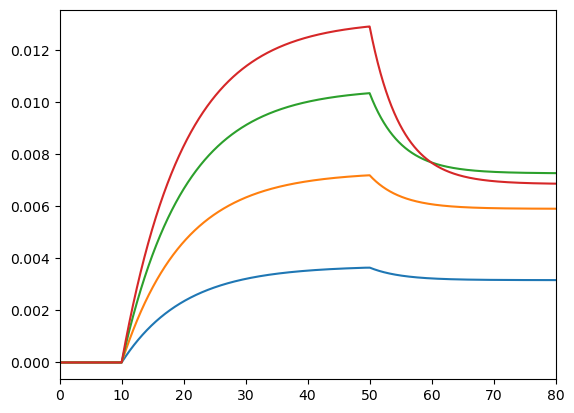

In [402]:
for key in PD_data:
    t, PDJt, PDQt=PD_data[key]
    plt.plot(t, PDQt, label=f'U2={key}')
    plt.xlim(0,80)

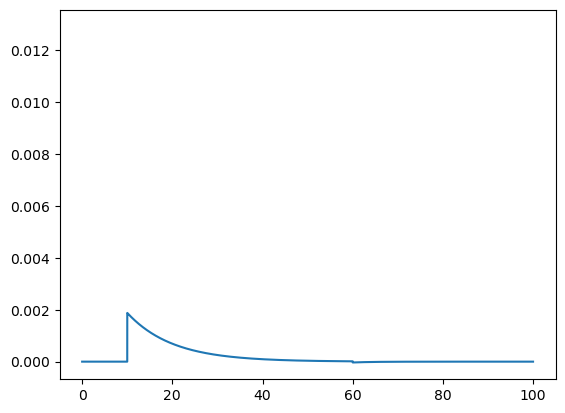

In [340]:
plt.plot(*PDQt)
plt.plot(*PDQt2)

9.663801962510947e-05 0.00187
-6.793501647319108e-07


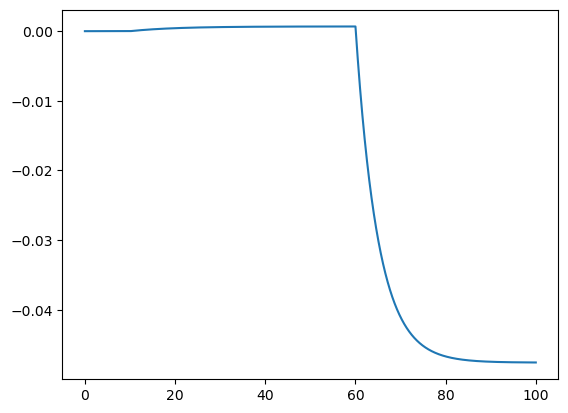

In [341]:
 # generate the PD-SpEC as currents - note the open circuit decay is
    # still a current even though the charge does not flow across the circuit
J=calculate_BEP_cat_current(all_thetas)
U2=1.6

Q1=Q_for_component_in_U_window(2, 0.1, U2, Q_all)
a1=calculate_a1_for_for_Q(Q=Q1, t=t, b1=0.1, t2=60)
J1=get_nearest_value_to_index(J, U2).values[0]
print(J1, Q1)
print(str_exp_dec(t=t,a=a1,b=0.1).cumsum().max())   
PDJ1=t,piecewise_exp_rise_str_exp_dec(t=t, a=a1, a1=J1, b=0.1, b1=1, t1=10, t2=60).cumsum()
plt.plot(*PDJ1)

<Axes: xlabel='U'>

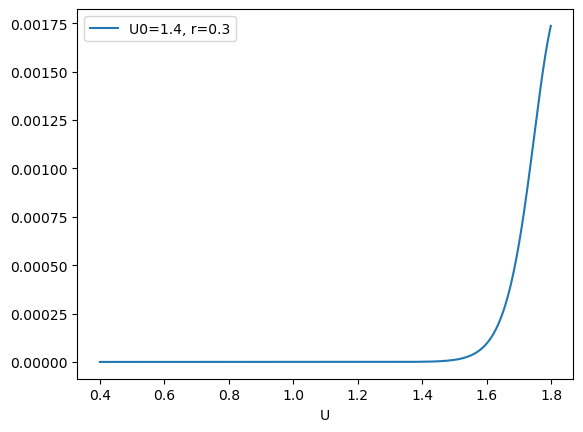

In [342]:
J.plot()


(700, 1) (700, 1)


0.0017533678161822178

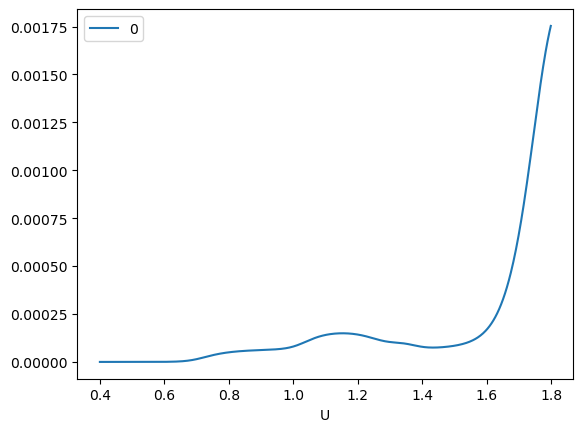

In [343]:
J=calculate_current(all_thetas, Q_max_all, scan_rate=scan_rate)
J.plot()
a=get_nearest_value_to_index(J, 1.9)
a.values.flatten()[0]

<Axes: xlabel='U'>

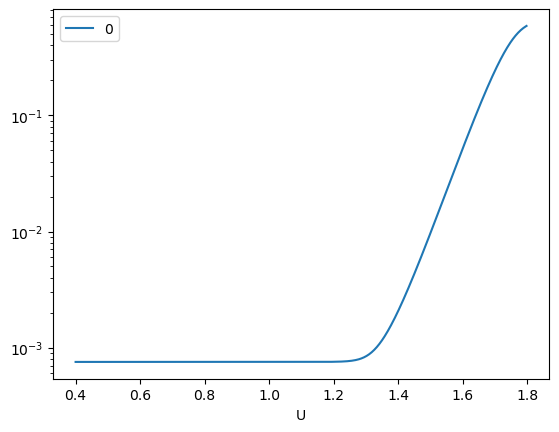

In [344]:
catcur=calculate_BEP_cat_current(all_thetas=all_thetas)
catcur.columns=[0]

Qf=pd.DataFrame(Q_all.iloc[:,-1])
Qf.columns=[0]

catcur.divide(Qf).plot(logy=True)

In [345]:
JBEP=calculate_BEP_cat_current(all_thetas=all_thetas)
IR=intrinsic_rate(Q_all=Q_all,J_BEP=JBEP)

#IR.index=all_thetas.iloc[:,-1]

#IR.plot(logy=False)

a=get_nearest_value_to_index(IR, 1.6).values[0]
a

0.05165686384001318

(0.0, 1.0)

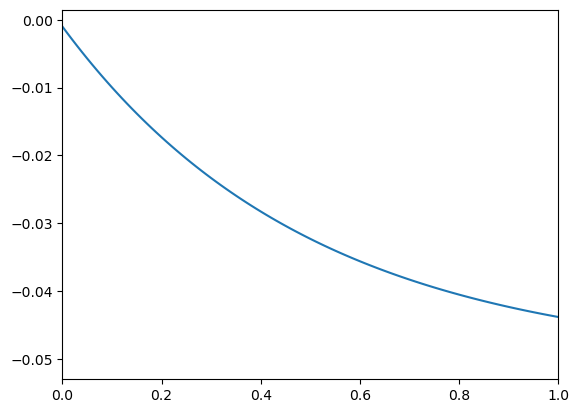

In [346]:
plt.plot(t,str_exp_dec(t=t,a=1E-3,b=10,alpha=0.2).cumsum())
plt.xlim(0,1)

In [347]:
calculate_b1_for_J(J=0.03,t=t,a1=0.001,t2=40,b_1_start=0.00001)

-0.28348036186549036

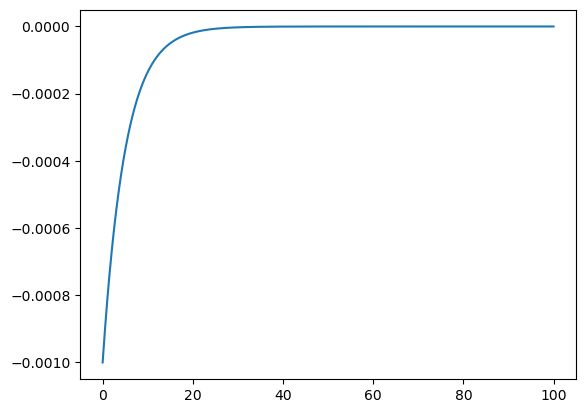

In [348]:
plt.plot(t,str_exp_dec(t=t,a=0.001,b=1
))

In [349]:
SpEC.to_parquet('SpEC.parquet')
all_thetas.to_parquet('thetas_ground_truth.parquet')
Q_all.to_parquet('Q_all_ground_truth.parquet')
J_total.to_parquet('J_SpEC.parquet')
all_thetas.to_parquet('all_thetas_ground_truth.parquet')
for name, df in SW_SpEC_all.items():
    df.to_parquet(f'SW_SpEC_{name}.parquet')


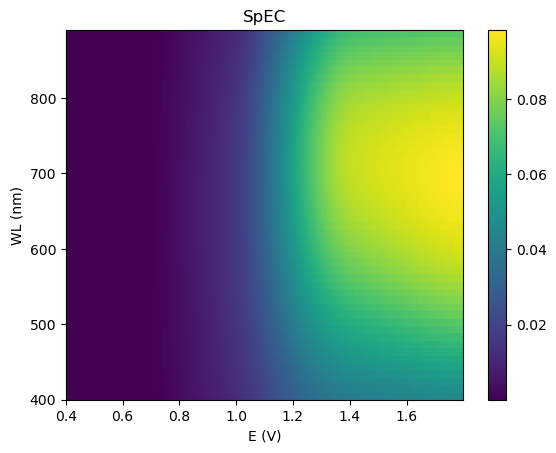

In [350]:
# plot SpEC as a heatmap using the viridis colormap
if __name__ == "__main__":
    plt.imshow(SpEC, aspect='auto', cmap='viridis', interpolation='none', extent=[E[0], E[-1], WLs[0], WLs[-1]])
    plt.colorbar()
    plt.xlabel('E (V)')
    plt.ylabel('WL (nm)')
    plt.title('SpEC')
    plt.show()